### Importing libraries


In [1]:
import pyreadr
import numpy as np
import pandas as pd
import seaborn as sns
from keras.models import Model
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.layers import Input, Dense, Conv1D, Flatten, Dropout, Bidirectional, LSTM, concatenate

### Importing Dataset


In [2]:
# Locating file in directories rather exposing the paths

import os


def search_file(start_dir, target_file):
    for dirpath, dirnames, filenames in os.walk(start_dir):
        if target_file in filenames:
            # print("Found {} at: {}".format(target_file, os.path.join(dirpath, target_file)))
            return os.path.join(dirpath, target_file)
    # print("File '{}' not found in '{}'".format(target_file, start_dir))
    return None


start_dir = "D:\\"

Fault_free_data = search_file(start_dir, "TEP_FaultFree_Training.RData")
Fault_data = search_file(start_dir, "TEP_Faulty_Training.RData")

In [3]:
df_FaultFree = pyreadr.read_r(Fault_free_data)['fault_free_training']
df_Faulty = pyreadr.read_r(Fault_data)['faulty_training']

In [4]:
# Join both fault free and faulty dataset
DF = pd.concat([df_FaultFree, df_Faulty])
DF.head()

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0.0,1.0,1,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,0.0,1.0,2,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,0.0,1.0,3,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,0.0,1.0,4,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,0.0,1.0,5,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461


### Preprocessing dataset


In [5]:
def SlidingWindow(df, w, s):
    X = []
    Y = []
    for i in range(0, len(df)-w, s):
        x = np.array(df.iloc[i:i+w, 3:])
        y = np.array(df.iloc[i+w-1, 0])
        X.append(x)
        Y.append(y)

    X = np.array(X)
    Y = np.array(Y)

    return X, Y

In [6]:
w = 20
s = 10

X = []
Y = []

for j in [x for x in range(0, 21) if x not in [9, 15]]:
    for i in range(1, 50):
        df = DF[(DF['faultNumber'] == j) & (
            DF['simulationRun'] == i) & (DF['sample'] > 20)]

        x_temp, y_temp = SlidingWindow(df, w, s)
        X.append(x_temp)
        Y.append(y_temp)

X = np.array(X).reshape((-1, w, x_temp.shape[-1]))
Y = np.array(Y).reshape((-1))

In [7]:
sc = StandardScaler()

reduced_data = DF[DF['faultNumber'] == 0]
fault_free = reduced_data[(reduced_data['faultNumber'] == 0)].iloc[:, 3:]

sc.fit(fault_free)

StandardScaler()

In [8]:
X_sc = sc.transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

c:\Users\saif_\miniconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [9]:
enc = OneHotEncoder(sparse=False)

enc.fit(Y.reshape(-1, 1))

Y_enc = enc.transform(Y.reshape(-1, 1))

c:\Users\saif_\miniconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [10]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    X_sc, Y_enc, test_size=0.2, random_state=42)

### Preparing neural network


In [11]:

def merged_model(X_train, y_train):
    # Define input layer
    input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

    # LSTM branch
    lstm_branch = Bidirectional(LSTM(128, activation="tanh", return_sequences=True))(input_layer)
    lstm_branch = LSTM(128, activation="tanh")(lstm_branch)

    # CNN branch
    cnn_branch = Conv1D(filters=32, kernel_size=3, activation='relu')(input_layer)
    cnn_branch = Conv1D(filters=32, kernel_size=3, activation='relu')(cnn_branch)
    cnn_branch = Flatten()(cnn_branch)

    # Merge LSTM and CNN branches
    merged = concatenate([lstm_branch, cnn_branch])

    # Dense layers
    decoded = Dense(300, activation='selu')(merged)
    decoded = Dropout(0.5)(decoded)
    decoded = Dense(y_train.shape[1], activation='softmax')(decoded)

    # Define the merged model
    merged_model = Model(inputs=input_layer, outputs=decoded)

    # Compile the model
    merged_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return merged_model


In [12]:

'''def CNN_model(X_train, y_train):
    # Define input layer
    input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

    # Define encoder layers
    encoded = Conv1D(filters=32, kernel_size=3, activation='relu')(input_layer)
    encoded = Conv1D(filters=32, kernel_size=3, activation='relu')(encoded)

    encoded = Flatten()(encoded)

    decoded = Dense(units=128, activation='relu')(encoded)
    decoded = Dropout(rate=0.5)(decoded)

    decoded = Dense(units=y_train.shape[1], activation='softmax')(decoded)

    # Define autoencoder model
    cnn_model = Model(inputs=input_layer, outputs=decoded)

    # Compile autoencoder model with additional regularization
    cnn_model.compile(loss='categorical_crossentropy',
                      optimizer='adam', metrics=['accuracy'])

    return cnn_model
'''

model = merged_model(x_train, y_train)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 52)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 18, 32)       5024        ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 20, 256)      185344      ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 16, 32)       3104        ['conv1d[0][0]']                 
                                                                                              

### Training model


Epoch 1/200
27/27 [==============================] - 9s 58ms/step - loss: 2.4105 - accuracy: 0.4499 - val_loss: 0.8891 - val_accuracy: 0.6981
Epoch 2/200
27/27 [==============================] - 1s 23ms/step - loss: 0.7129 - accuracy: 0.7497 - val_loss: 0.5310 - val_accuracy: 0.8064
Epoch 3/200
27/27 [==============================] - 1s 23ms/step - loss: 0.4212 - accuracy: 0.8532 - val_loss: 0.3928 - val_accuracy: 0.8733
Epoch 4/200
27/27 [==============================] - 1s 22ms/step - loss: 0.2722 - accuracy: 0.9114 - val_loss: 0.3304 - val_accuracy: 0.8952
Epoch 5/200
27/27 [==============================] - 1s 23ms/step - loss: 0.1829 - accuracy: 0.9450 - val_loss: 0.2793 - val_accuracy: 0.9199
Epoch 6/200
27/27 [==============================] - 1s 23ms/step - loss: 0.1198 - accuracy: 0.9622 - val_loss: 0.2086 - val_accuracy: 0.9382
Epoch 7/200
27/27 [==============================] - 1s 22ms/step - loss: 0.0857 - accuracy: 0.9737 - val_loss: 0.2413 - val_accuracy: 0.9329
Epoch 

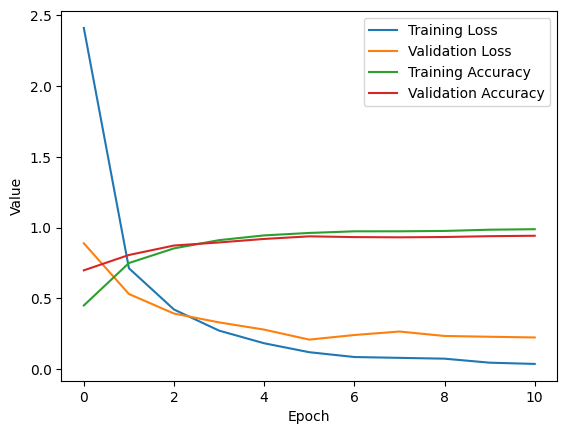

In [13]:
# Define early stopping callback to monitor validation loss and stop if it doesn't improve for 5 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=5)
# Create model
model = merged_model(x_train, y_train)
# Train the model with 20 epochs and batch size of 32, using the early stopping callback
history = model.fit(x_train[::5, :], y_train[::5], epochs=200, batch_size=256,
                    validation_data=(x_test, y_test), callbacks=[early_stop])

# Plot the training history for loss and accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

### Evaluating the model


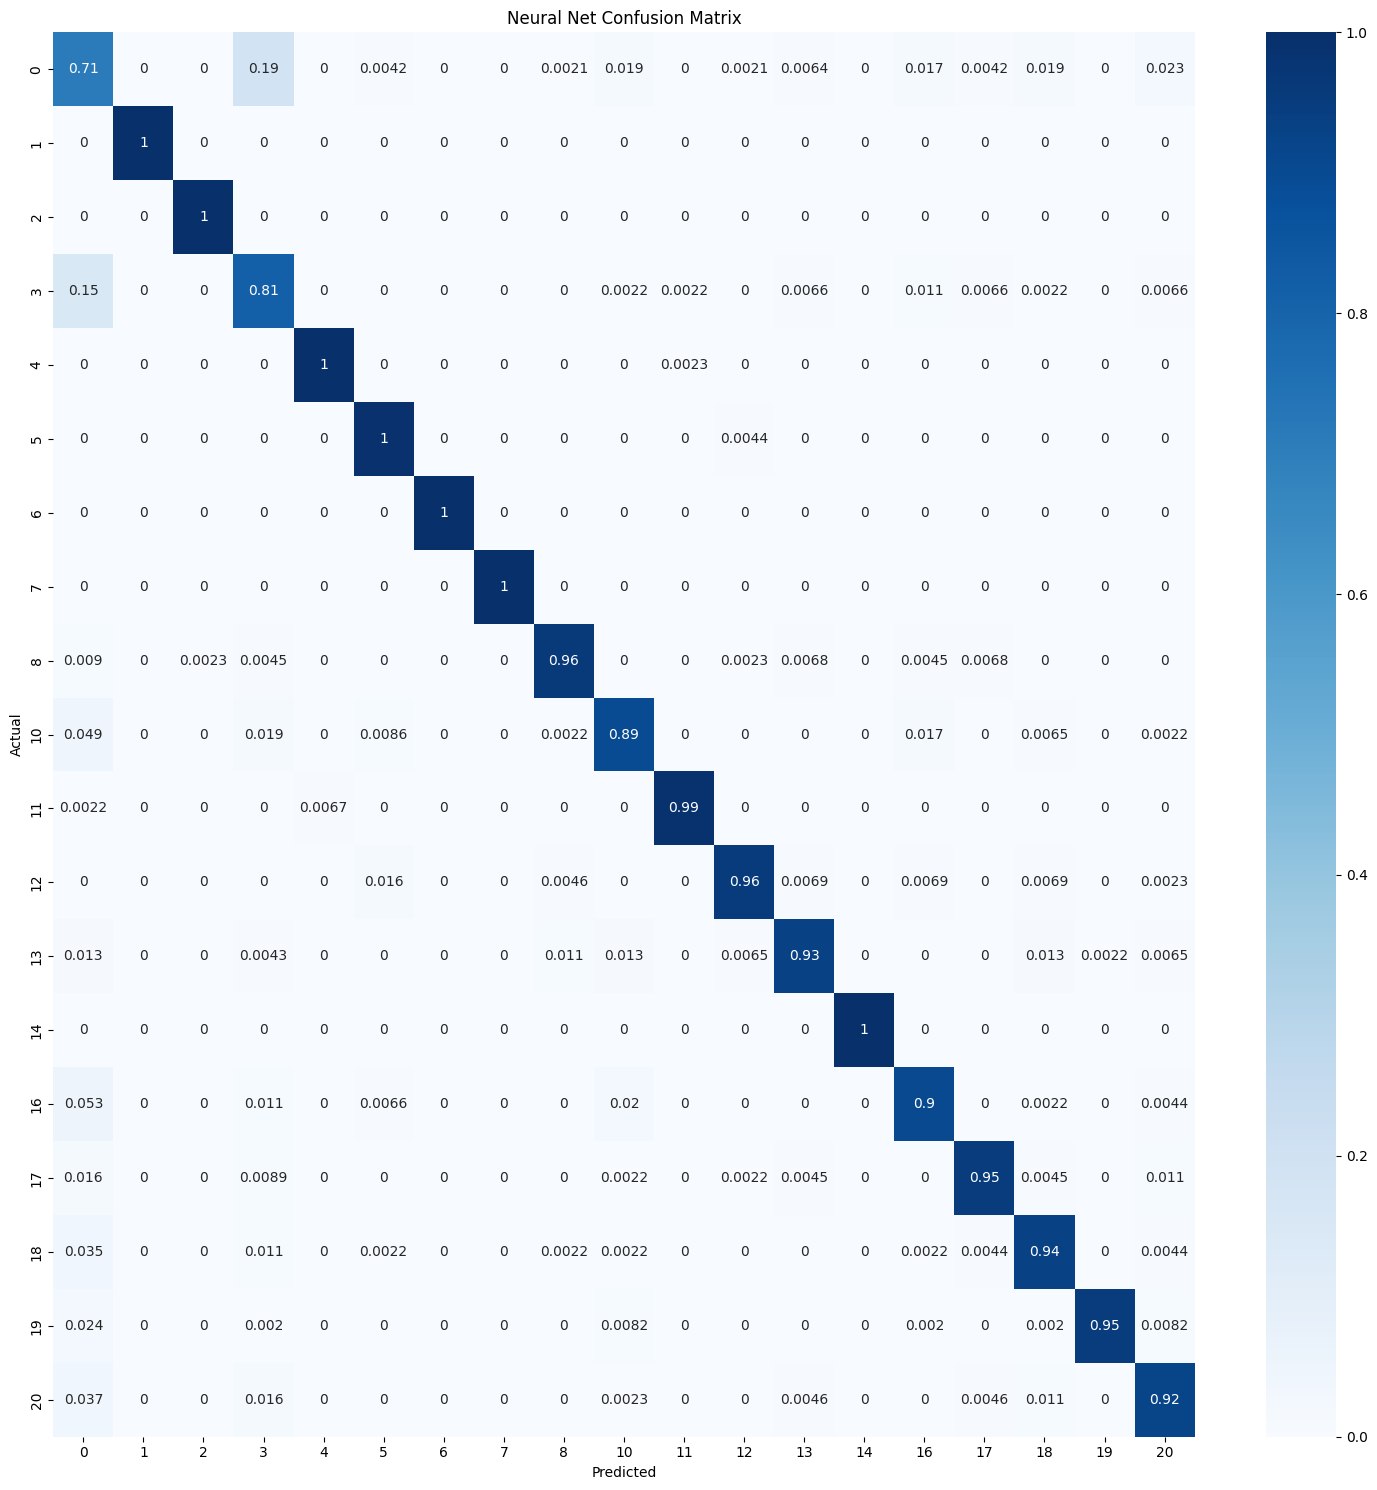

Neural Net accuracy_score: 0.9423301424235349


In [14]:
# Create a function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    f, ax = plt.subplots(figsize=(15, 15))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, cmap='Blues', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticklabels([str(x) for x in range(0, 21) if x not in [9, 15]])
    ax.set_yticklabels([str(x) for x in range(0, 21) if x not in [9, 15]])
    ax.set_ylim(len(cm), 0)
    plt.tight_layout()
    plt.show()


y_pred = enc.inverse_transform(model.predict(x_test, verbose=0))
y_true = enc.inverse_transform(y_test)

# Plot the confusion matrix and print the f1 score for each algorithm
plot_confusion_matrix(y_true, y_pred, 'Neural Net Confusion Matrix')
print("Neural Net accuracy_score:", accuracy_score(y_true, y_pred))

### Realtime fault prediction


c:\Users\saif_\miniconda3\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


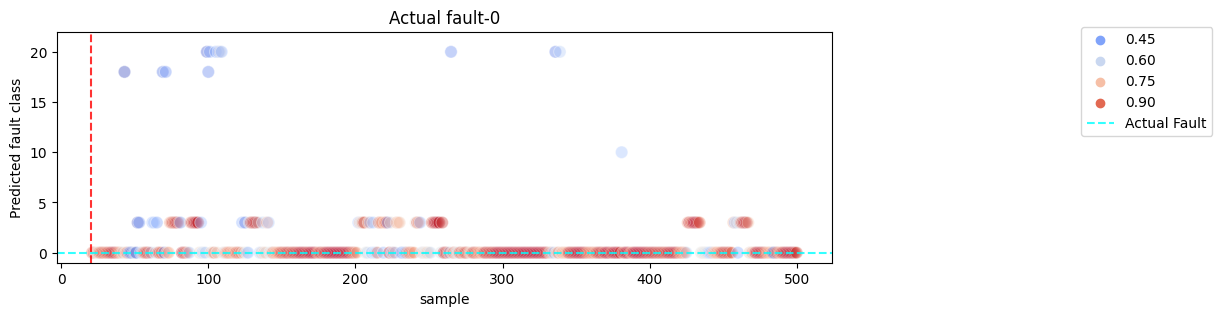

c:\Users\saif_\miniconda3\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


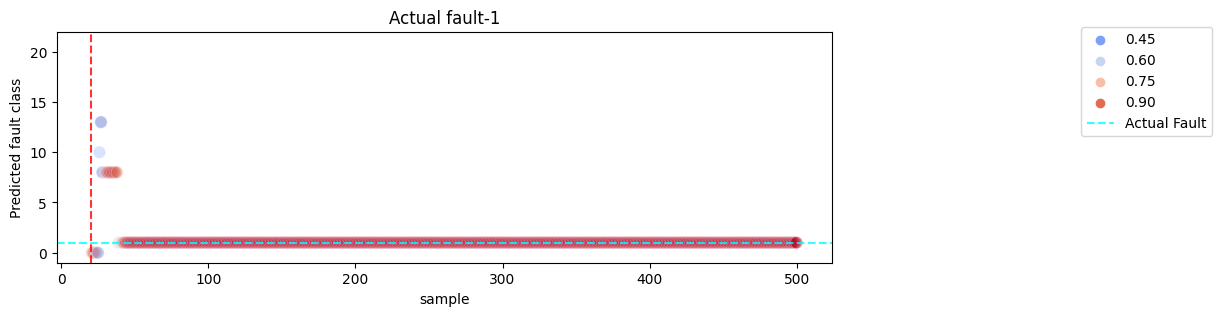

c:\Users\saif_\miniconda3\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


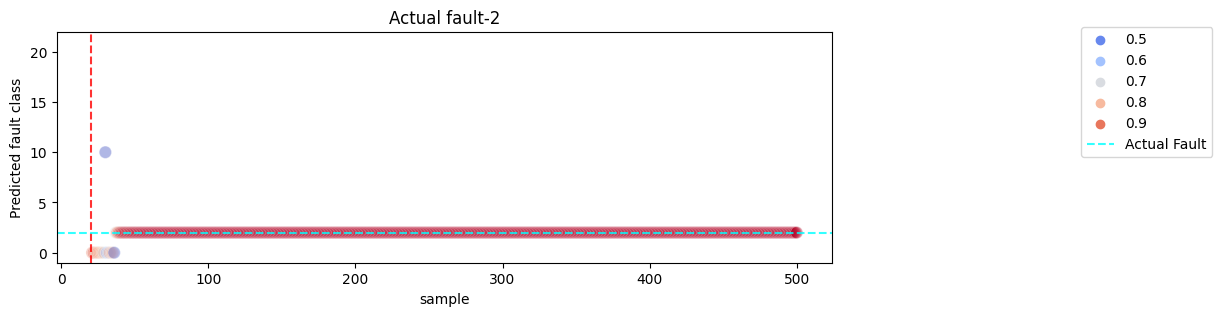

c:\Users\saif_\miniconda3\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


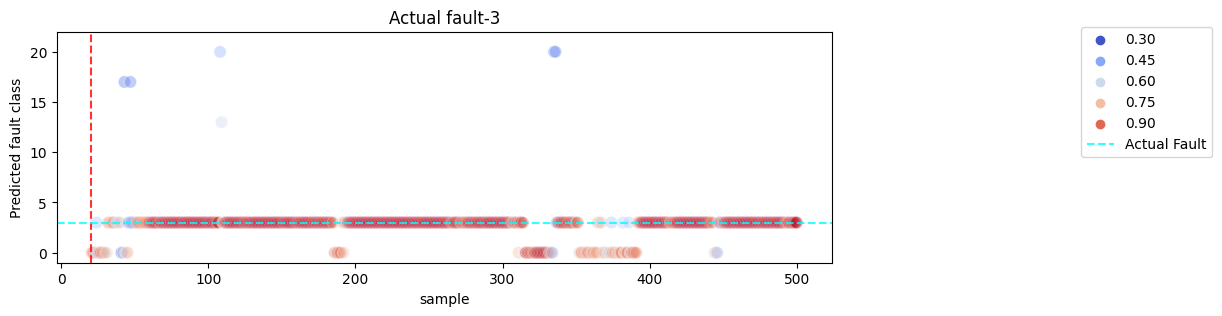

c:\Users\saif_\miniconda3\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


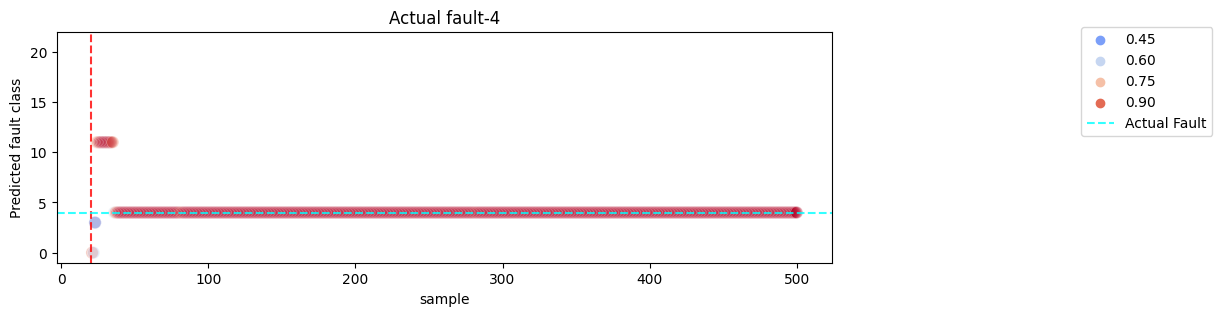

c:\Users\saif_\miniconda3\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


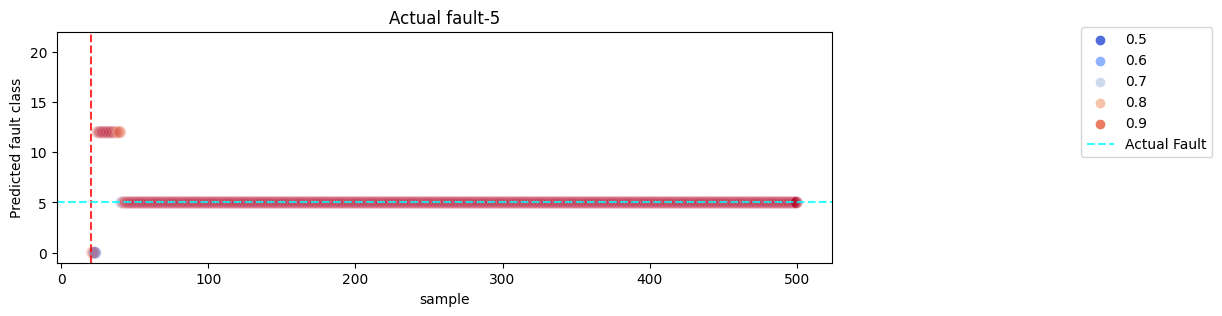

c:\Users\saif_\miniconda3\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


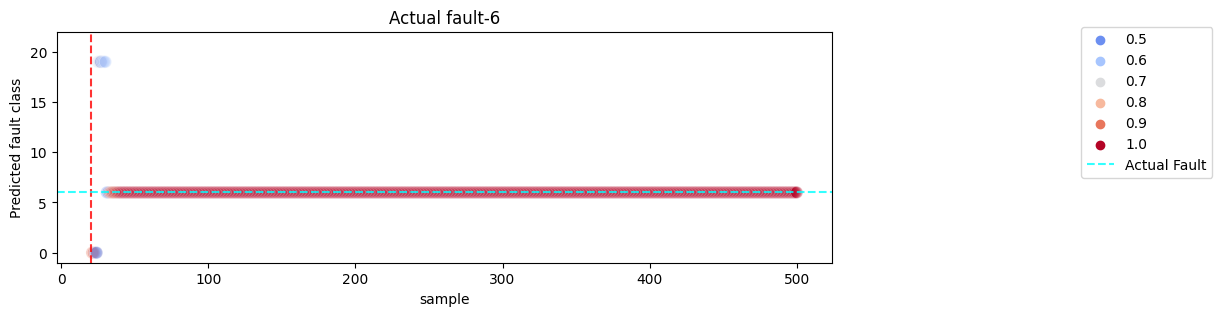

c:\Users\saif_\miniconda3\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


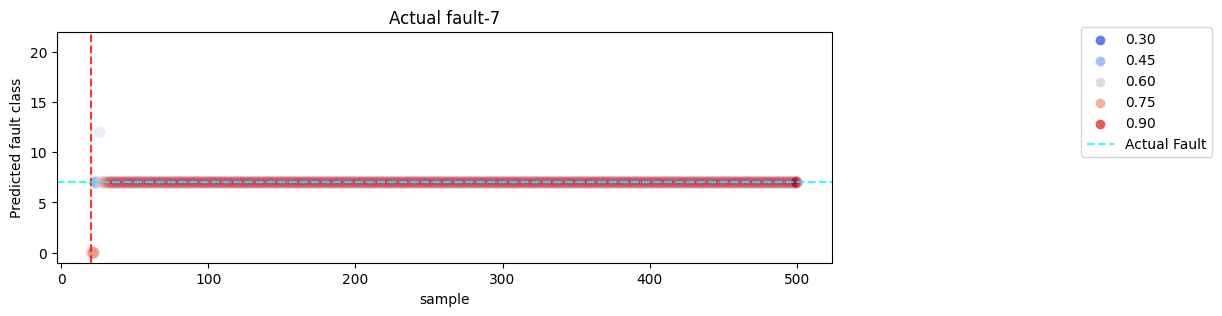

c:\Users\saif_\miniconda3\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


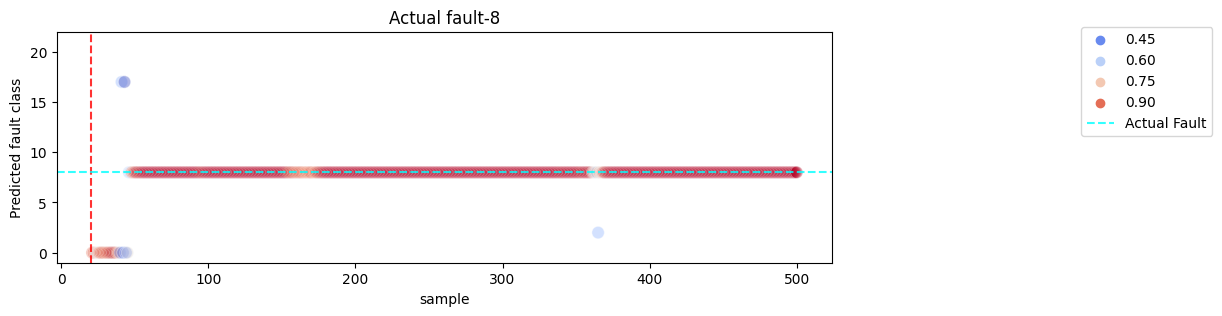

c:\Users\saif_\miniconda3\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


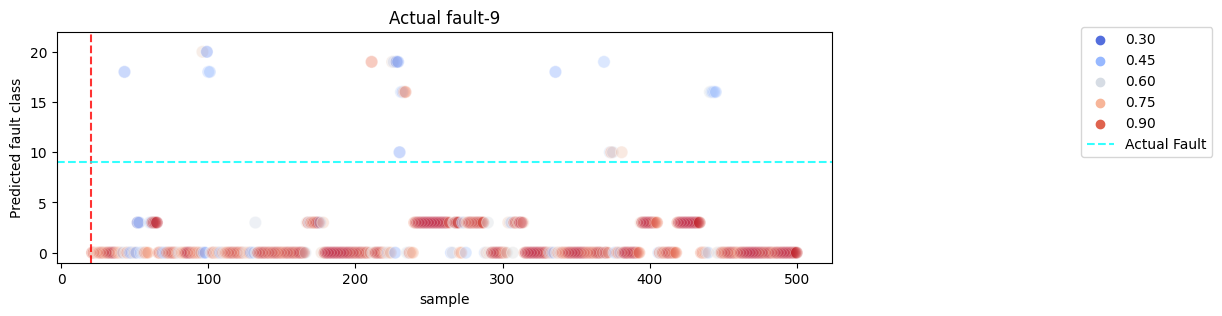

c:\Users\saif_\miniconda3\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


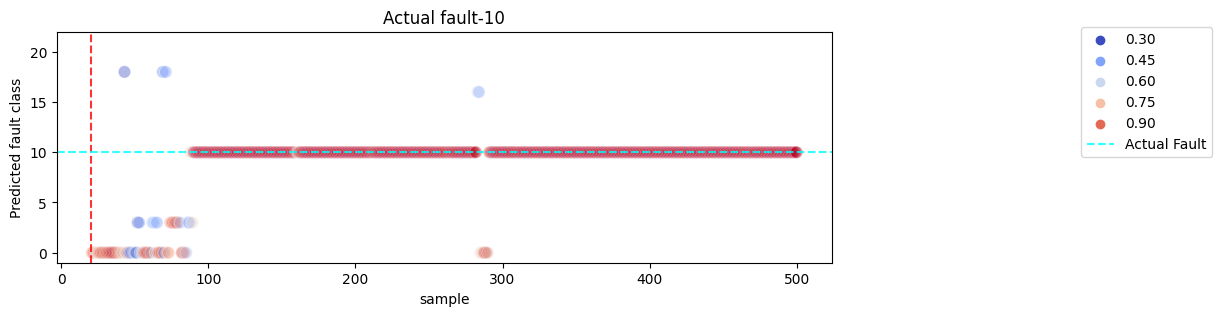

c:\Users\saif_\miniconda3\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


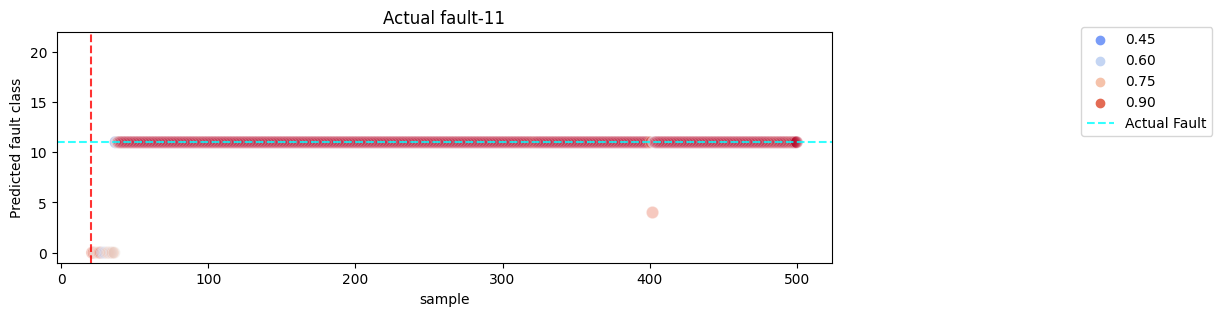

c:\Users\saif_\miniconda3\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


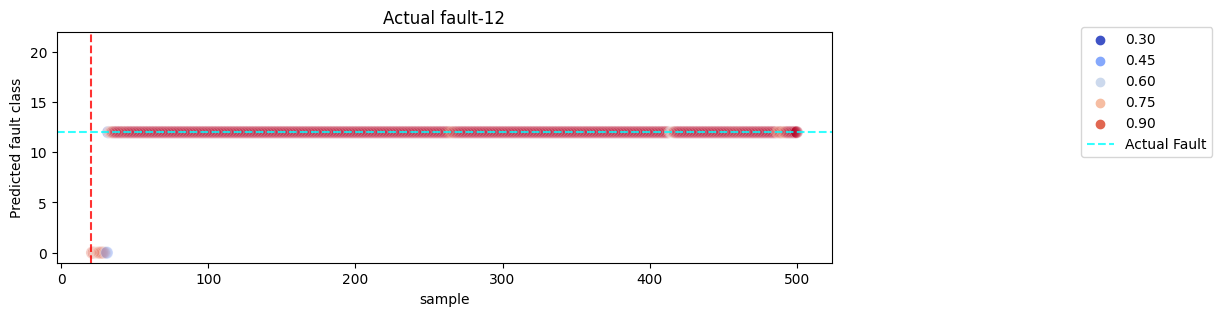

c:\Users\saif_\miniconda3\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


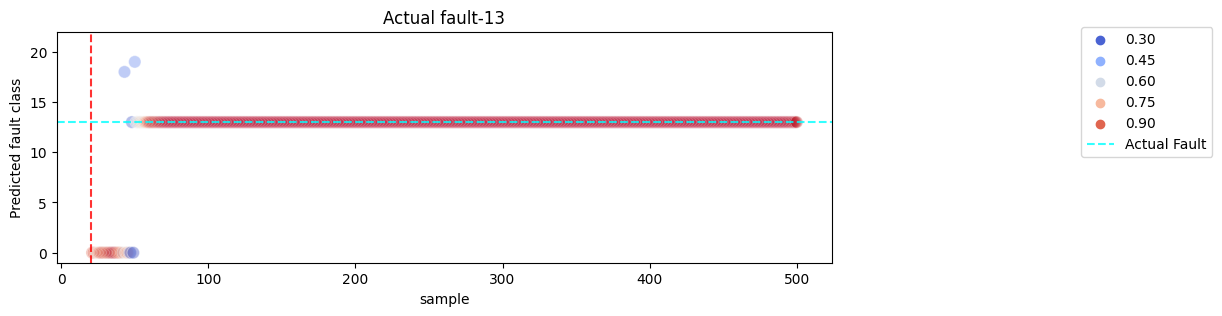

c:\Users\saif_\miniconda3\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


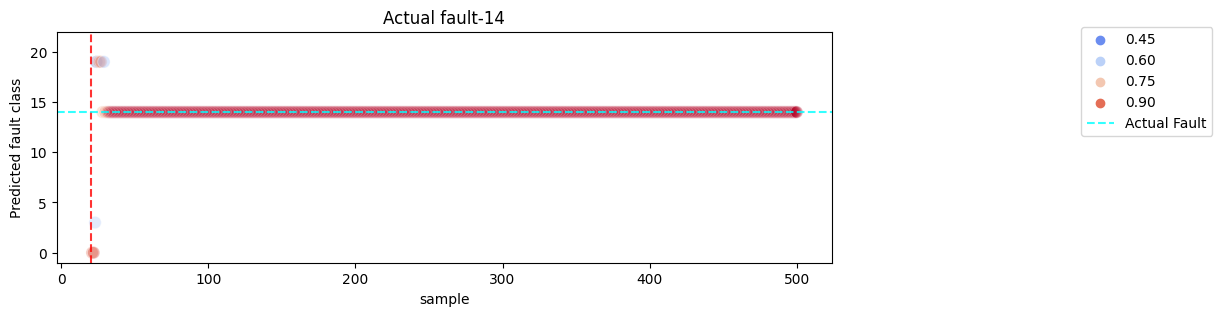

c:\Users\saif_\miniconda3\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


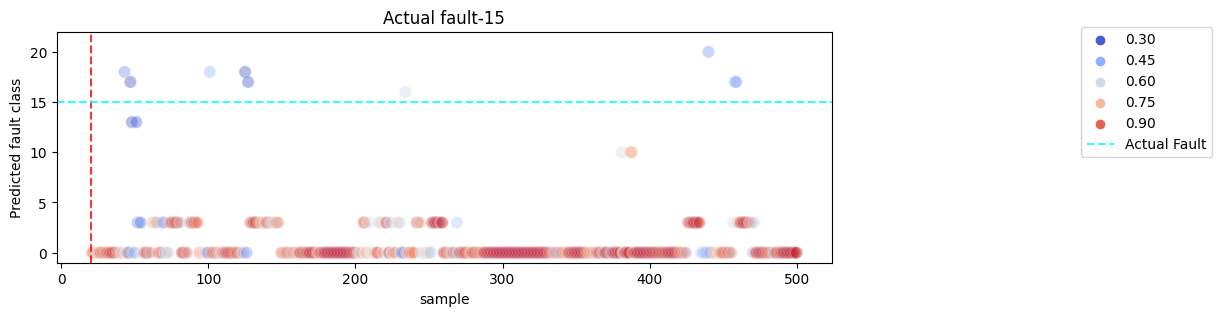

c:\Users\saif_\miniconda3\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


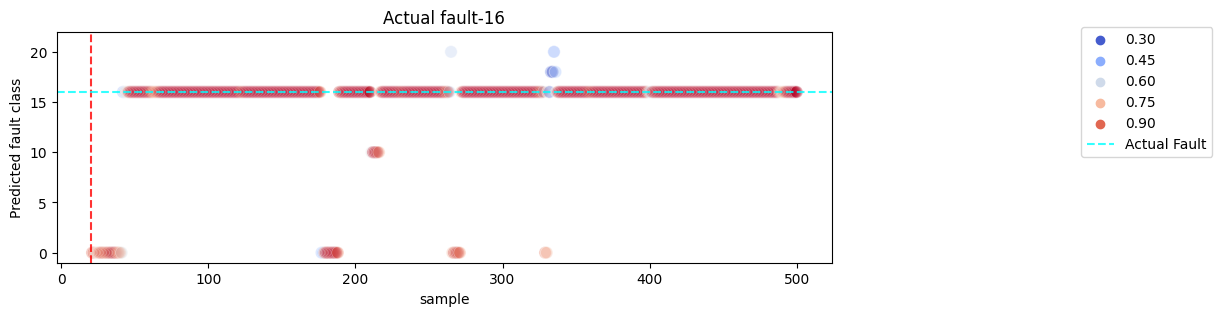

c:\Users\saif_\miniconda3\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


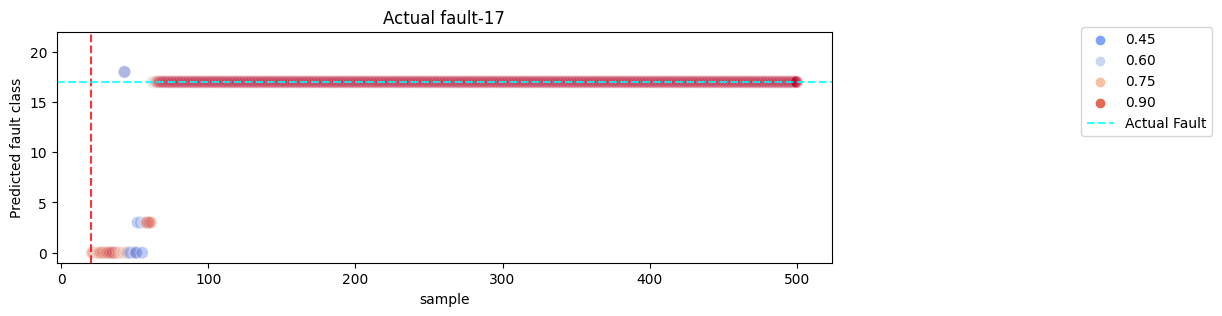

c:\Users\saif_\miniconda3\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


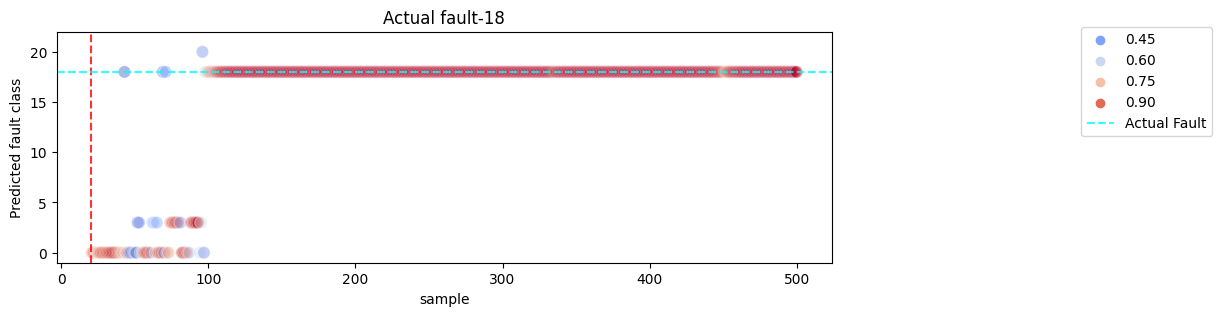

c:\Users\saif_\miniconda3\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


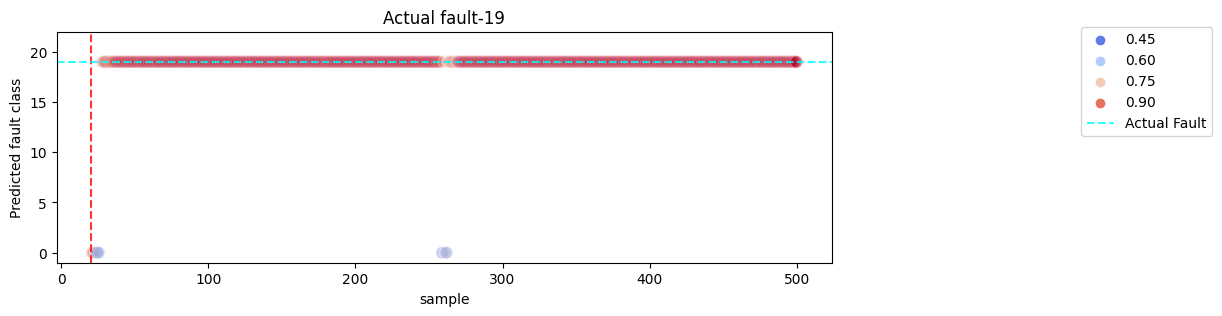

c:\Users\saif_\miniconda3\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


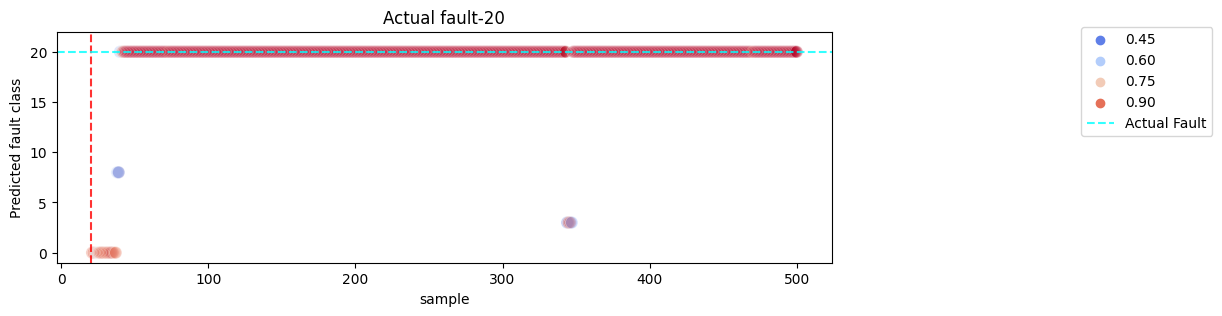

In [15]:
for F_num in range(0, 21):
    # select the fault data each fault
    df_new = DF[(DF['faultNumber'] == F_num) &
                (DF['simulationRun'] == 1)].copy()
    # normalize the data
    df_new.iloc[:, 3:] = sc.transform(df_new.iloc[:, 3:])

    # create sliding window data
    x_new, y_new = SlidingWindow(df_new, w=20, s=1)

    # predict fault class and probability for each sliding window
    y_pred = enc.inverse_transform(model.predict(x_new, verbose=0))
    y_proba = np.max(model.predict(x_new, verbose=0), axis=1)

    # plot the results
    f, ax = plt.subplots(figsize=(10, 3))
    sns.scatterplot(x=df_new['sample'][w:], y=y_pred[:, 0], hue=y_proba,
                    palette="coolwarm", s=80, alpha=0.4, vmin=0, vmax=1)
    plt.axvline(20, c='r', alpha=0.8, linestyle='--')
    plt.axhline(F_num, c='cyan', alpha=0.8,
                label='Actual Fault', linestyle='--')
    plt.legend(bbox_to_anchor=(1.5, 1.05))
    plt.ylabel('Predicted fault class')
    plt.ylim([-1, 22])
    plt.title(f'Actual fault-{F_num}')
    plt.show()

In [16]:
Accuracy = []
# For each fault number in the dataset
for Fnum in [x for x in range(0, 21) if x not in [3, 9, 15]]:
    # Get data for a random simulation run
    df_new = DF[(DF['faultNumber'] == F_num) & (
        DF['simulationRun'] == np.random.randint(1, 500))].copy()
    # Preprocess data using StandardScaler
    df_new.iloc[:, 3:] = sc.transform(df_new.iloc[:, 3:])

    # Generate sliding windows from data
    x_new, y_true = SlidingWindow(df_new, w=w, s=1)
    y_pred = enc.inverse_transform(model.predict(x_new, verbose=0))
    # Calculate accuracy of predicted fault
    acc = accuracy_score(y_true, y_pred)
    print(f'The accuracy for Fault_num={Fnum} is {acc}')
    # Append accuracy to list
    Accuracy.append(acc)

print("#"*20)
print(f'The overall accuracy is {np.mean(Accuracy)}')

The accuracy for Fault_num=0 is 0.8958333333333334
The accuracy for Fault_num=1 is 0.9291666666666667
The accuracy for Fault_num=2 is 0.9770833333333333
The accuracy for Fault_num=4 is 0.94375
The accuracy for Fault_num=5 is 0.89375
The accuracy for Fault_num=6 is 0.9458333333333333
The accuracy for Fault_num=7 is 0.9333333333333333
The accuracy for Fault_num=8 is 0.9541666666666667
The accuracy for Fault_num=10 is 0.8791666666666667
The accuracy for Fault_num=11 is 0.8875
The accuracy for Fault_num=12 is 0.9166666666666666
The accuracy for Fault_num=13 is 0.8854166666666666
The accuracy for Fault_num=14 is 0.9375
The accuracy for Fault_num=16 is 0.8791666666666667
The accuracy for Fault_num=17 is 0.9416666666666667
The accuracy for Fault_num=18 is 0.9458333333333333
The accuracy for Fault_num=19 is 0.91875
The accuracy for Fault_num=20 is 0.85625
####################
The overall accuracy is 0.917824074074074


### t-SNE visualisation to analyze model clustering performance


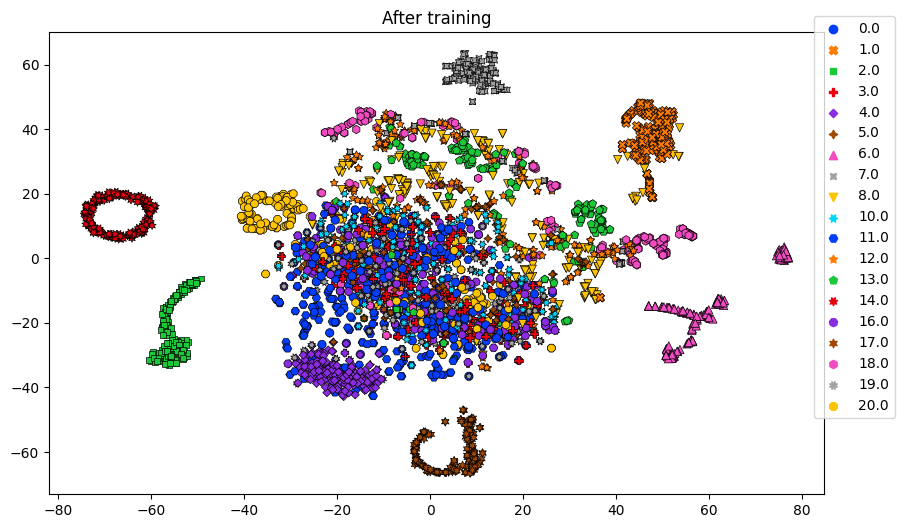

In [17]:
# Reduce the dimensionality of the training data using t-SNE
x_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(
    x_train[::10, :].reshape(len(x_train[::10, :]), -1))
# Retrieve the original labels for the reduced data
y_label = enc.inverse_transform(y_train[::10, :]).reshape(-1)
# Create a scatterplot of the reduced data with different colors for each class
f, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=x_embedded[:, 0], y=x_embedded[:, 1], hue=y_label,
                style=y_label, palette="bright", edgecolor='black')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('After training')
plt.show()

In [18]:
intermediate_model = Model(inputs=model.input, outputs=model.layers[-2].output)
intermediate_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 20, 52)]     0           []                               
                                                                                                  
 conv1d_2 (Conv1D)              (None, 18, 32)       5024        ['input_2[0][0]']                
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 20, 256)     185344      ['input_2[0][0]']                
 )                                                                                                
                                                                                                  
 conv1d_3 (Conv1D)              (None, 16, 32)       3104        ['conv1d_2[0][0]']         

108/108 [==============================] - 1s 6ms/step


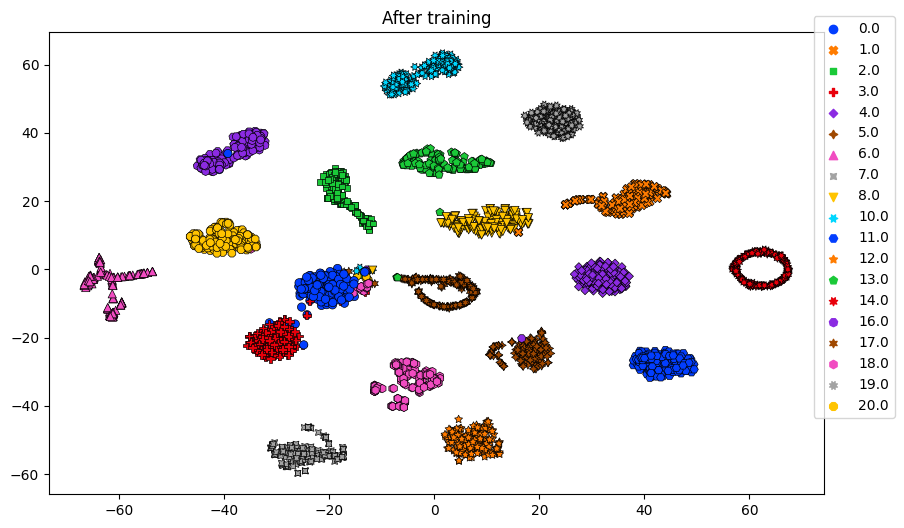

In [19]:
# Get the intermediate output for every 10th data point in the training set
x_inter = intermediate_model.predict(x_train[::10, :])
# Use t-SNE to reduce the dimensionality of the intermediate output to 2D
x_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(x_inter)
# Get the true labels for every data point in the training set
y_label = enc.inverse_transform(y_train[::10, :]).reshape(-1)
# Create a scatter plot of the embedded data, colored by the true labels
f, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=x_embedded[:, 0], y=x_embedded[:, 1], hue=y_label,
                style=y_label, palette="bright", edgecolor='black')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('After training')
plt.show()